In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

import tqdm

# Baseline model

1. Train set: Use data from 7am - 17pm in train set
2. Test set: To evaluate, only evaluate prediction from 9am - 17pm 
3. Impute missing for all data by linear interpolation, fill forward and backward
4. Scale min max, fit train set
5. Train features to predict their futures by LSTM
6. Train features with response to predict response by Regression

In [10]:
def impute_missing(data):
    """
    data: DataFrame
    """

    features = data.columns
    for feature in features:
        data[feature] = data[feature].interpolate(method='nearest', limit_direction='both')
        data[feature] = data[feature].ffill()
        data[feature] = data[feature].bfill()

    return data


def scale_min_max(fit_data):
    """
    train_set, test_set: numpy array
    """
    minmax_scaler = MinMaxScaler().fit(fit_data)
    data_scaled = minmax_scaler.transform(fit_data)
    # val_set_scaled = minmax_scaler.transform(val_set)
    # test_set_scaled = minmax_scaler.transform(test_set)

    return data_scaled, minmax_scaler


def feature_differencing(time_feature, lag):
    diff_feat = time_feature[:-lag]
    diff_feat = np.append(diff_feat.values[:lag], diff_feat)
    return diff_feat
    
    
def add_features(data, time_col):
    data['hour'] = pd.to_datetime(data[time_col]).dt.hour
    
    return data
    
    
def window_data(data, look_back_num):
    """
    data: numpy array
    """
    X_train = []
    y_train = []

    # # input X, each look_back_num points is corresponding to 1 y (y dim is 5)
    for i in range(look_back_num, data.shape[0]):
        X_train.append(data[i-look_back_num:i, :])
        y_train.append(data[i, :])

    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], data.shape[1]))  # num obs * time sequence length * num features

    return X_train, y_train


# Modelling

def lstm_model(X_train, y_train, epochs, batch_size):
    regressor = Sequential()
    regressor.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))  # each input is time sequence length * num features
    regressor.add(LSTM(units = 64))
    regressor.add(Dropout(0.2))

    # output layer
    regressor.add(Dense(units=y_train.shape[1]))
    regressor.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    # regressor.summary()
    history = regressor.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, verbose=False)

    return regressor, history

def train_model(loc, look_back_num, epochs, batch_size):
    ## LSTM

    train_file = os.path.join(os.getcwd(), "data/avg_data_10min_wh/loc_{i}/fold_4/train.csv".format(i=loc))
    train_set = pd.read_csv(train_file, encoding='utf-8')
    train_set = add_features(train_set, 'DateTime')
    train_set['power_lag1'] = feature_differencing(train_set['Power(mW)'], 1)
    train_set['power_lag60'] = feature_differencing(train_set['Power(mW)'], 60)

    features = ['hour', 'WindSpeed(m/s)','Pressure(hpa)','Temperature(°C)','Humidity(%)','Sunlight(Lux)', 'power_lag1', 'power_lag60', 'Power(mW)']
    # features = ['Pressure(hpa)','Temperature(°C)','Humidity(%)','Sunlight(Lux)', 'Power(mW)']
    X_features = features[:-1]
    
    # get log
#     train_set[features[1:]] = np.log(train_set[features[1:]] + 1)
    
    train_imputed = impute_missing(train_set[features])
    # print(np.sum(np.isnan(train_imputed)))
    # train_imputed = train_set[features].dropna()
    train_scaled, minmax_scaler = scale_min_max(train_imputed[X_features])
    X_train, X_train_later = window_data(train_scaled, look_back_num)
    regressor, history = lstm_model(X_train, X_train_later, epochs, batch_size)

    ## Regression

    y_train = np.log(train_imputed[['Power(mW)']] + 1)
    lin_reg = LinearRegression(n_jobs=5)
    lin_reg.fit(train_scaled, y_train)

    return minmax_scaler, regressor, history, lin_reg

In [8]:
def lstm_predict(model, forecast_num, look_back_num, X_test):
    # Only apply for look_back_num = 12 and forecast_num = 48
    predictions = []

    i = 0
    complete_day = (len(X_test) + look_back_num) // (forecast_num + look_back_num)
    interval_left = (len(X_test) + look_back_num) % (forecast_num + look_back_num)
    if (interval_left == 0): 
        count = forecast_num
    else:
        count = interval_left

    while i < len(X_test) - count: 
        if i > forecast_num:
            i += look_back_num

        input_seq = X_test[i].reshape(1, X_test.shape[1], X_test.shape[2])
        for _ in range(forecast_num):
            next_pred = model.predict(input_seq, verbose=False)
            predictions.append(next_pred[0])
            input_seq = np.append(input_seq[:, 1:, :], [[next_pred[0]]], axis=1)
        i += forecast_num

    if (interval_left >= look_back_num):
        predictions = np.array(predictions)[:(complete_day * forecast_num) + interval_left - look_back_num]
    else:
        predictions = np.array(predictions)[:(complete_day * forecast_num)]

    return np.array(predictions)


def predict_power(loc, look_back_num, forecast_num, lstm_regressor, lin_reg, minmax_scaler):
    test_file = os.path.join(os.getcwd(), "data/avg_data_10min_wh/loc_{i}/fold_4/test.csv".format(i=loc))
    test_set = pd.read_csv(test_file, encoding='utf-8')
    test_set = add_features(test_set, 'DateTime')
    test_set['power_lag1'] = feature_differencing(test_set['Power(mW)'], 1)
    test_set['power_lag60'] = feature_differencing(test_set['Power(mW)'], 60)
    test_set['is_missing'] = np.where(test_set['Power(mW)'].isna(), 1, 0)

    features = ['hour', 'WindSpeed(m/s)','Pressure(hpa)','Temperature(°C)','Humidity(%)','Sunlight(Lux)', 'power_lag1', 'power_lag60', 'Power(mW)']
    # features = ['Pressure(hpa)','Temperature(°C)','Humidity(%)','Sunlight(Lux)', 'Power(mW)']
    X_features = features[:-1]
    
    # get log
#     test_set[features[1:]] = np.log(test_set[features[1:]] + 1)
    
    test_imputed = impute_missing(test_set[features])
    test_scaled = minmax_scaler.transform(test_imputed[X_features])
    X_test, _ = window_data(test_scaled, look_back_num)
    X_test_pred = lstm_predict(lstm_regressor, forecast_num, look_back_num, X_test)

    X_test_true = pd.concat([test_set[['DateTime', 'is_missing']], test_imputed], axis=1)
    hour_dt = pd.to_datetime(X_test_true["DateTime"]).dt.time
    X_test_true = X_test_true[(hour_dt >= pd.to_datetime("09:00").time()) & 
                            (hour_dt < pd.to_datetime("17:00").time())]
    y_test = X_test_true['Power(mW)']
    y_pred = lin_reg.predict(X_test_pred).reshape(y_test.shape[0])
    y_pred = np.exp(y_pred) - 1
#     y_test = np.exp(y_test) - 1

    return X_test_true, X_test_pred, y_pred, y_test, X_test_true[['DateTime', 'is_missing']]


In [11]:
location_lst = range(1, 18, 1)
look_back_num = 12
forecast_num = 48

all_predictions = pd.DataFrame(columns = ["datetime", "location", "y_test", "y_pred"])
for loc in location_lst:
    print(loc)
    minmax_scaler, regressor, history, lin_reg = train_model(loc, look_back_num=look_back_num, epochs=300, batch_size=512)
    X_test_true, X_test_pred, y_pred, y_test, date_miss = predict_power(loc, look_back_num=look_back_num, 
                                                             forecast_num=forecast_num, lstm_regressor=regressor, 
                                                             lin_reg=lin_reg, minmax_scaler=minmax_scaler)
    df = pd.DataFrame(columns = ["datetime", "location", "y_test", "y_pred", "is_missing"])
    df["datetime"] = date_miss['DateTime']
    df["is_missing"] = date_miss['is_missing']
    df["location"] = loc
    df["y_test"] = y_test
    df["y_pred"] = y_pred
    print("MAE of location {i}: ".format(i=loc), np.mean(np.abs(df['y_test'] - df['y_pred'])))

    all_predictions = pd.concat([all_predictions, df])

1
MAE of location 1:  584.8243289244685
2
MAE of location 2:  384.79823260821973
3
MAE of location 3:  8272.282271244792
4
MAE of location 4:  496.2269042233052
5
MAE of location 5:  626.8938509066983
6
MAE of location 6:  577.3186986149711
7
MAE of location 7:  502.9252946319713
8
MAE of location 8:  111.72932886164932
9
MAE of location 9:  226.76037932409733
10
MAE of location 10:  453.0068513080092
11
MAE of location 11:  13.489464887912826
12
MAE of location 12:  540.1618548463009
13
MAE of location 13:  332.3446657965973
14
MAE of location 14:  401.9385159521915
15
MAE of location 15:  563.9633364293489
16
MAE of location 16:  585.1339582137106
17
MAE of location 17:  388.94145237378024


In [18]:
mae = np.mean(np.abs(all_predictions['y_test'] - all_predictions['y_pred']))
mae

455.64363979339225

In [19]:
no_missing = all_predictions[all_predictions['is_missing'] == 0]
mae = np.mean(np.abs(no_missing['y_test'] - no_missing['y_pred']))
mae

470.19489577111347

In [15]:
## Retrain 3 because it looks weird

loc=3
minmax_scaler, regressor, history, lin_reg = train_model(loc, look_back_num=look_back_num, epochs=300, batch_size=512)
X_test_true, X_test_pred, y_pred, y_test, date_miss = predict_power(loc, look_back_num=look_back_num, 
                                                         forecast_num=forecast_num, lstm_regressor=regressor, 
                                                         lin_reg=lin_reg, minmax_scaler=minmax_scaler)
df = pd.DataFrame(columns = ["datetime", "location", "y_test", "y_pred", "is_missing"])
df["datetime"] = date_miss['DateTime']
df["is_missing"] = date_miss['is_missing']
df["location"] = loc
df["y_test"] = y_test
df["y_pred"] = y_pred
print("MAE of location {i}: ".format(i=loc), np.mean(np.abs(df['y_test'] - df['y_pred'])))

MAE of location 3:  1590.1381620925763


In [17]:
# all_predictions = all_predictions.reset_index(drop=True)
all_predictions.loc[all_predictions['location'] == 3, :] = df

In [144]:
all_predictions.loc[11767:12858, 'location'] = 12

In [149]:
no_missing = all_predictions[all_predictions['is_missing'] == 0]
mae = np.mean(np.abs(no_missing['y_test'] - no_missing['y_pred']))
mae

432.3412562823701

In [150]:
all_predictions.to_csv("output/output_lag1.csv", index=False)

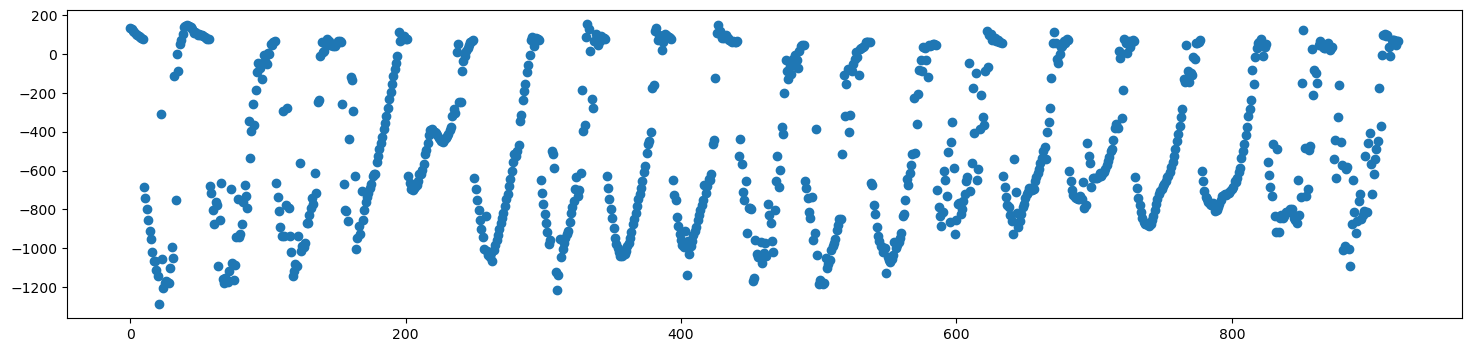

In [21]:
plt.figure(figsize=(18, 28))
y_ax = no_missing.loc[no_missing['location'] == 2, 'y_pred'] - no_missing.loc[no_missing['location'] == 2, 'y_test'] 

plt.subplot(6, 1, 1)
# plt.plot(np.arange(2000), np.arange(2000))
plt.scatter(np.arange(len(y_ax)), y_ax)

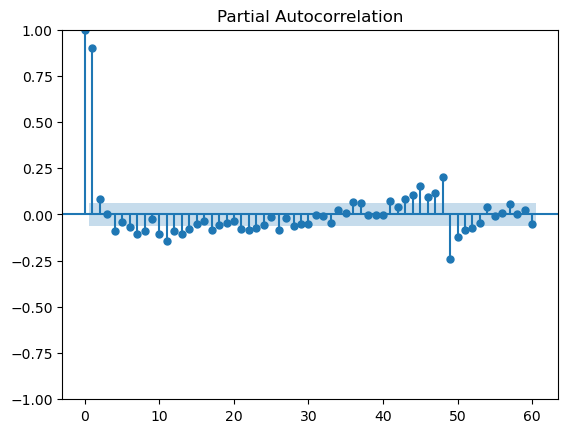

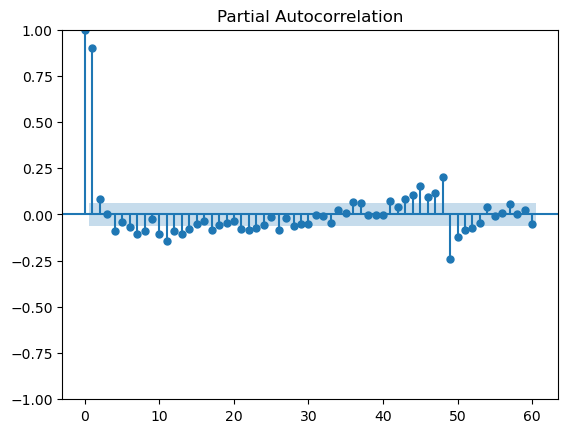

In [ ]:
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# plot_pacf(y_ax, lags=60)

In [101]:
no_missing.loc[no_missing['location'] == 5, 'y_test'].shape

(576,)

# Baseline (without windspeed)

In [7]:
location_lst = range(1, 18, 1)
look_back_num = 12
forecast_num = 48

all_predictions = pd.DataFrame(columns = ["datetime", "location", "y_test", "y_pred"])
for loc in location_lst:
    print(loc)
    minmax_scaler, regressor, history, lin_reg = train_model(loc, look_back_num=look_back_num, epochs=500, batch_size=512)
    X_test_true, X_test_pred, y_pred, y_test, date_miss = predict_power(loc, look_back_num=look_back_num, 
                                                             forecast_num=forecast_num, lstm_regressor=regressor, 
                                                             lin_reg=lin_reg, minmax_scaler=minmax_scaler)
    df = pd.DataFrame(columns = ["datetime", "location", "y_test", "y_pred", "is_missing"])
    df["datetime"] = date_miss['DateTime']
    df["is_missing"] = date_miss['is_missing']
    df["location"] = loc
    df["y_test"] = y_test
    df["y_pred"] = y_pred
    print("MAE of location {i}: ".format(i=loc), np.mean(np.abs(df['y_test'] - df['y_pred'])))

    all_predictions = pd.concat([all_predictions, df])

1
MAE of location 1:  2565.461643806146
2
MAE of location 2:  362.86356925642275
3
MAE of location 3:  1441.455912933955
4
MAE of location 4:  659.2662560568165
5
MAE of location 5:  748.7796853483253
6
MAE of location 6:  562.2626608133307
7
MAE of location 7:  966.483484117751
8
MAE of location 8:  161.8023780989333
9
MAE of location 9:  230.6848413639127
10
MAE of location 10:  1092.0922996320612
11
MAE of location 11:  15.014703090918925
12
MAE of location 12:  510.9939710950664
13
MAE of location 13:  531.0760744192472
14
MAE of location 14:  425.99017836995523
15
MAE of location 15:  553.1719322121623
16
MAE of location 16:  588.081290298157
17
MAE of location 17:  473.2310054823779


In [8]:
no_missing = all_predictions[all_predictions['is_missing'] == 0]
mae = np.mean(np.abs(no_missing['y_test'] - no_missing['y_pred']))
mae

764.8591096328307

In [9]:
all_predictions.to_csv("output/output_baseline_no_wind.csv", index=False)

In [11]:
train_file = os.path.join(os.getcwd(), "avg_data_10min_wh/loc_{i}/fold_4/train.csv".format(i=1))
train_set = pd.read_csv(train_file, encoding='utf-8')
train_set.head()

,DateTime,LocationCode,WindSpeed(m/s),Pressure(hpa),Temperature(°C),Humidity(%),Sunlight(Lux),Power(mW)
0,2024-01-01 07:00:00,1.0,0.00000,1016.730,17.50,86.99,470.834,0.083
1,2024-01-01 07:10:00,1.0,0.00000,1016.774,17.57,86.97,659.667,0.139
2,2024-01-01 07:20:00,1.0,0.68193,1016.922,17.63,86.18,889.666,0.247
3,2024-01-01 07:30:00,1.0,0.60737,1016.992,17.74,85.41,1263.833,0.447
4,2024-01-01 07:40:00,1.0,0.00000,1017.094,17.90,85.41,2136.833,1.129


In [13]:
train_set['DateTime']

0        2024-01-01 07:00:00
1        2024-01-01 07:10:00
2        2024-01-01 07:20:00
3        2024-01-01 07:30:00
4        2024-01-01 07:40:00
                ...         
10315    2024-06-20 16:10:00
10316    2024-06-20 16:20:00
10317    2024-06-20 16:30:00
10318    2024-06-20 16:40:00
10319    2024-06-20 16:50:00
Name: DateTime, Length: 10320, dtype: object